In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import requests
from urllib.parse import quote
import concurrent.futures

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", message="Glyph .* missing from current font")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

In [3]:
from config import META_DATA_FOLDER_PATH, START_DATE, END_DATE
from data_utils import get_article_domain_tuples
from meta_data_utils import sanitize_filename

In [4]:
article_domain_tuples = get_article_domain_tuples()

In [5]:
from concurrent.futures import ThreadPoolExecutor

def read_and_append_file(article_domain_tuple, folder_path):
    article, domain = article_domain_tuple
    sanitized_article = sanitize_filename(article)
    file_path = os.path.join(folder_path, f"{sanitized_article}_{domain}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['article'] = article
        df['domain'] = domain
        return df
    return pd.DataFrame()  # Return an empty DataFrame if the file does not exist

def concatenate_csv_files(article_domain_tuples, folder_path, max_workers=4):
    combined_df = pd.DataFrame()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(read_and_append_file, article_domain_tuples, [folder_path]*len(article_domain_tuples)), total=len(article_domain_tuples)))

    combined_df = pd.concat(results, ignore_index=True)
    return combined_df

combined_df = concatenate_csv_files(article_domain_tuples, META_DATA_FOLDER_PATH, max_workers=8)
combined_df.to_csv('combined_articles_data.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39802/39802 [01:31<00:00, 436.03it/s]


In [49]:
combined_df['date'] = pd.to_datetime(combined_df['date'])

meta_df = combined_df[(combined_df['date'] >= START_DATE) & (combined_df['date'] <= END_DATE)]

In [50]:
meta_df.shape

(2787696, 22)

### Missing Values

In [8]:
meta_df.isna().sum()

date                          0
total_edits                   0
total_bytes_added             0
unique_editors                0
mobile edit                   0
mobile web edit               0
visualeditor                  0
mw-reverted                   0
mw-undo                       0
mw-rollback                   0
mobile app edit               0
android app edit              0
ios app edit                  0
contenttranslation            0
visualeditor-switched         0
mw-new-redirect               0
mw-removed-redirect           0
mw-blank                      0
mw-changed-redirect-target    0
end_of_day_size               0
article                       0
domain                        0
dtype: int64

**No Missing Values**

### Count the Number of Edit Days per Article-Domain Combination

In [42]:
edit_days_count = meta_df.groupby(['article', 'domain'])['date'].nunique().reset_index()
edit_days_count.columns = ['article', 'domain', 'edit_days_count']
edit_days_count

,article,domain,edit_days_count
0,"""Weird_Al""_Yankovic",en.wikipedia.org,147
1,'Tis_the_Season,en.wikipedia.org,27
2,'Tis_the_Season_(Vince_Gill_and_Olivia_Newton-...,en.wikipedia.org,2
3,(1)_Ceres,de.wikipedia.org,53
4,(500)_Days_of_Summer,es.wikipedia.org,20
...,...,...,...
37094,龍涎香,zh.wikipedia.org,9
37095,龔嘉欣,zh.wikipedia.org,174
37096,龙生九子,zh.wikipedia.org,16
37097,대문,commons.wikimedia.org,5


### Visualize the Distribution of Edit Days

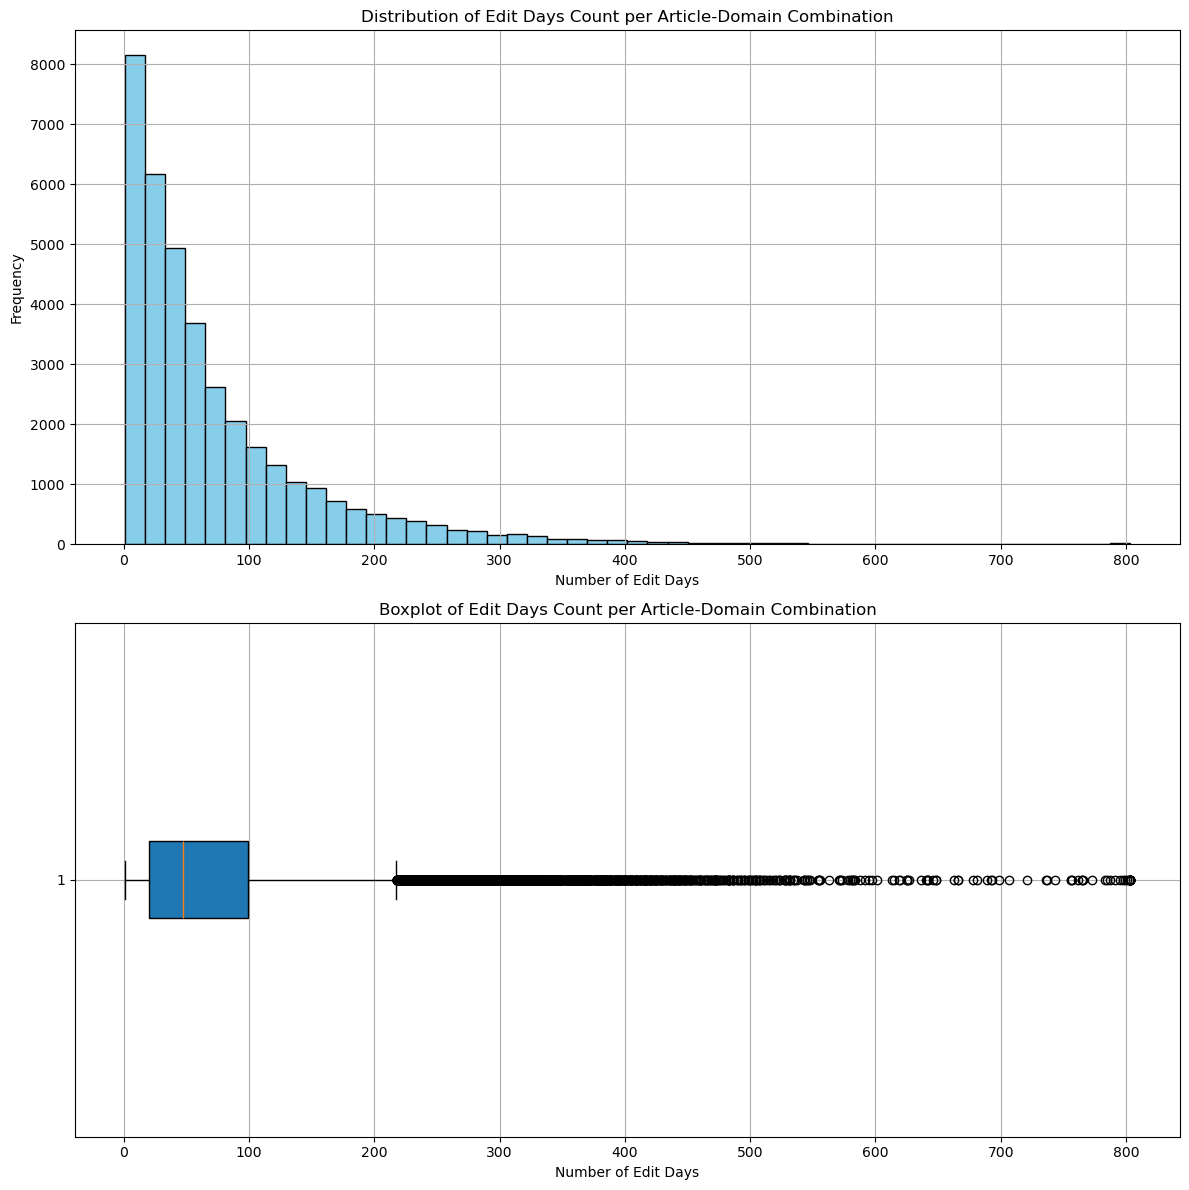

In [55]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plot the histogram
axes[0].hist(edit_days_count['edit_days_count'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Edit Days Count per Article-Domain Combination')
axes[0].set_xlabel('Number of Edit Days')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the boxplot
axes[1].boxplot(edit_days_count['edit_days_count'], vert=False, patch_artist=True)
axes[1].set_title('Boxplot of Edit Days Count per Article-Domain Combination')
axes[1].set_xlabel('Number of Edit Days')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


### Distribution of Total Edits per Article-Domain Combination

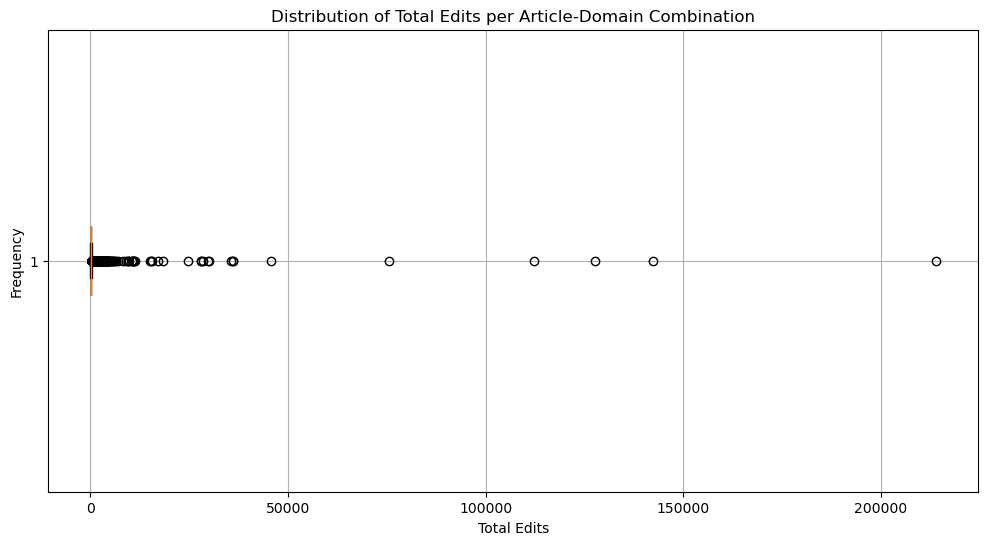

In [54]:
# Sum the total edits per article-domain combination
total_edits_count = meta_df.groupby(['article', 'domain'])['total_edits'].sum().reset_index()
total_edits_count.columns = ['article', 'domain', 'total_edits']

# Plot the distribution of total edits count
plt.figure(figsize=(12, 6))
plt.boxplot(total_edits_count['total_edits'], vert=False, patch_artist=True)
plt.title('Distribution of Total Edits per Article-Domain Combination')
plt.xlabel('Total Edits')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Time Series Plot of Total Edits Over Time

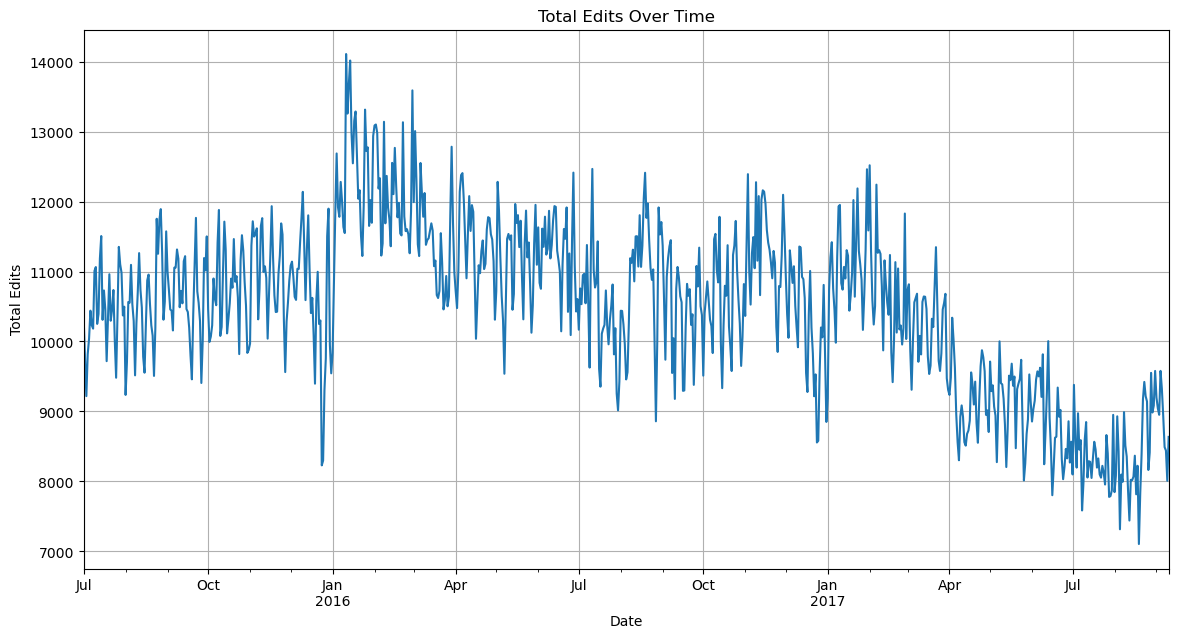

In [9]:
# Plotting total edits over time
plt.figure(figsize=(14, 7))
meta_df.groupby('date')['total_edits'].sum().plot()
plt.title('Total Edits Over Time')
plt.xlabel('Date')
plt.ylabel('Total Edits')
plt.grid(True)
plt.show()


In [64]:
numerical_features = [
    'total_edits', 'total_bytes_added', 'unique_editors',
    'mobile edit', 'mobile web edit', 'visualeditor', 'mw-reverted',
    'mw-undo', 'mw-rollback', 'mobile app edit', 'android app edit',
    'ios app edit', 'contenttranslation', 'visualeditor-switched',
    'mw-new-redirect', 'mw-removed-redirect', 'mw-blank',
    'mw-changed-redirect-target', 'end_of_day_size'
]

In [74]:
def check_all_zero_columns(df, numerical_features):
    all_zero_columns = []
    
    for feature in numerical_features:
        if (df[feature] == 0).all():
            all_zero_columns.append(feature)
    
    return all_zero_columns

all_zero_columns = check_all_zero_columns(meta_df, numerical_features)
all_zero_columns

['mw-undo',
 'mw-rollback',
 'android app edit',
 'ios app edit',
 'mw-new-redirect',
 'mw-removed-redirect',
 'mw-blank',
 'mw-changed-redirect-target']

In [76]:
meta_df = meta_df.drop(columns=all_zero_columns)

In [80]:
numerical_features = [feature for feature in numerical_features if feature not in all_zero_columns]

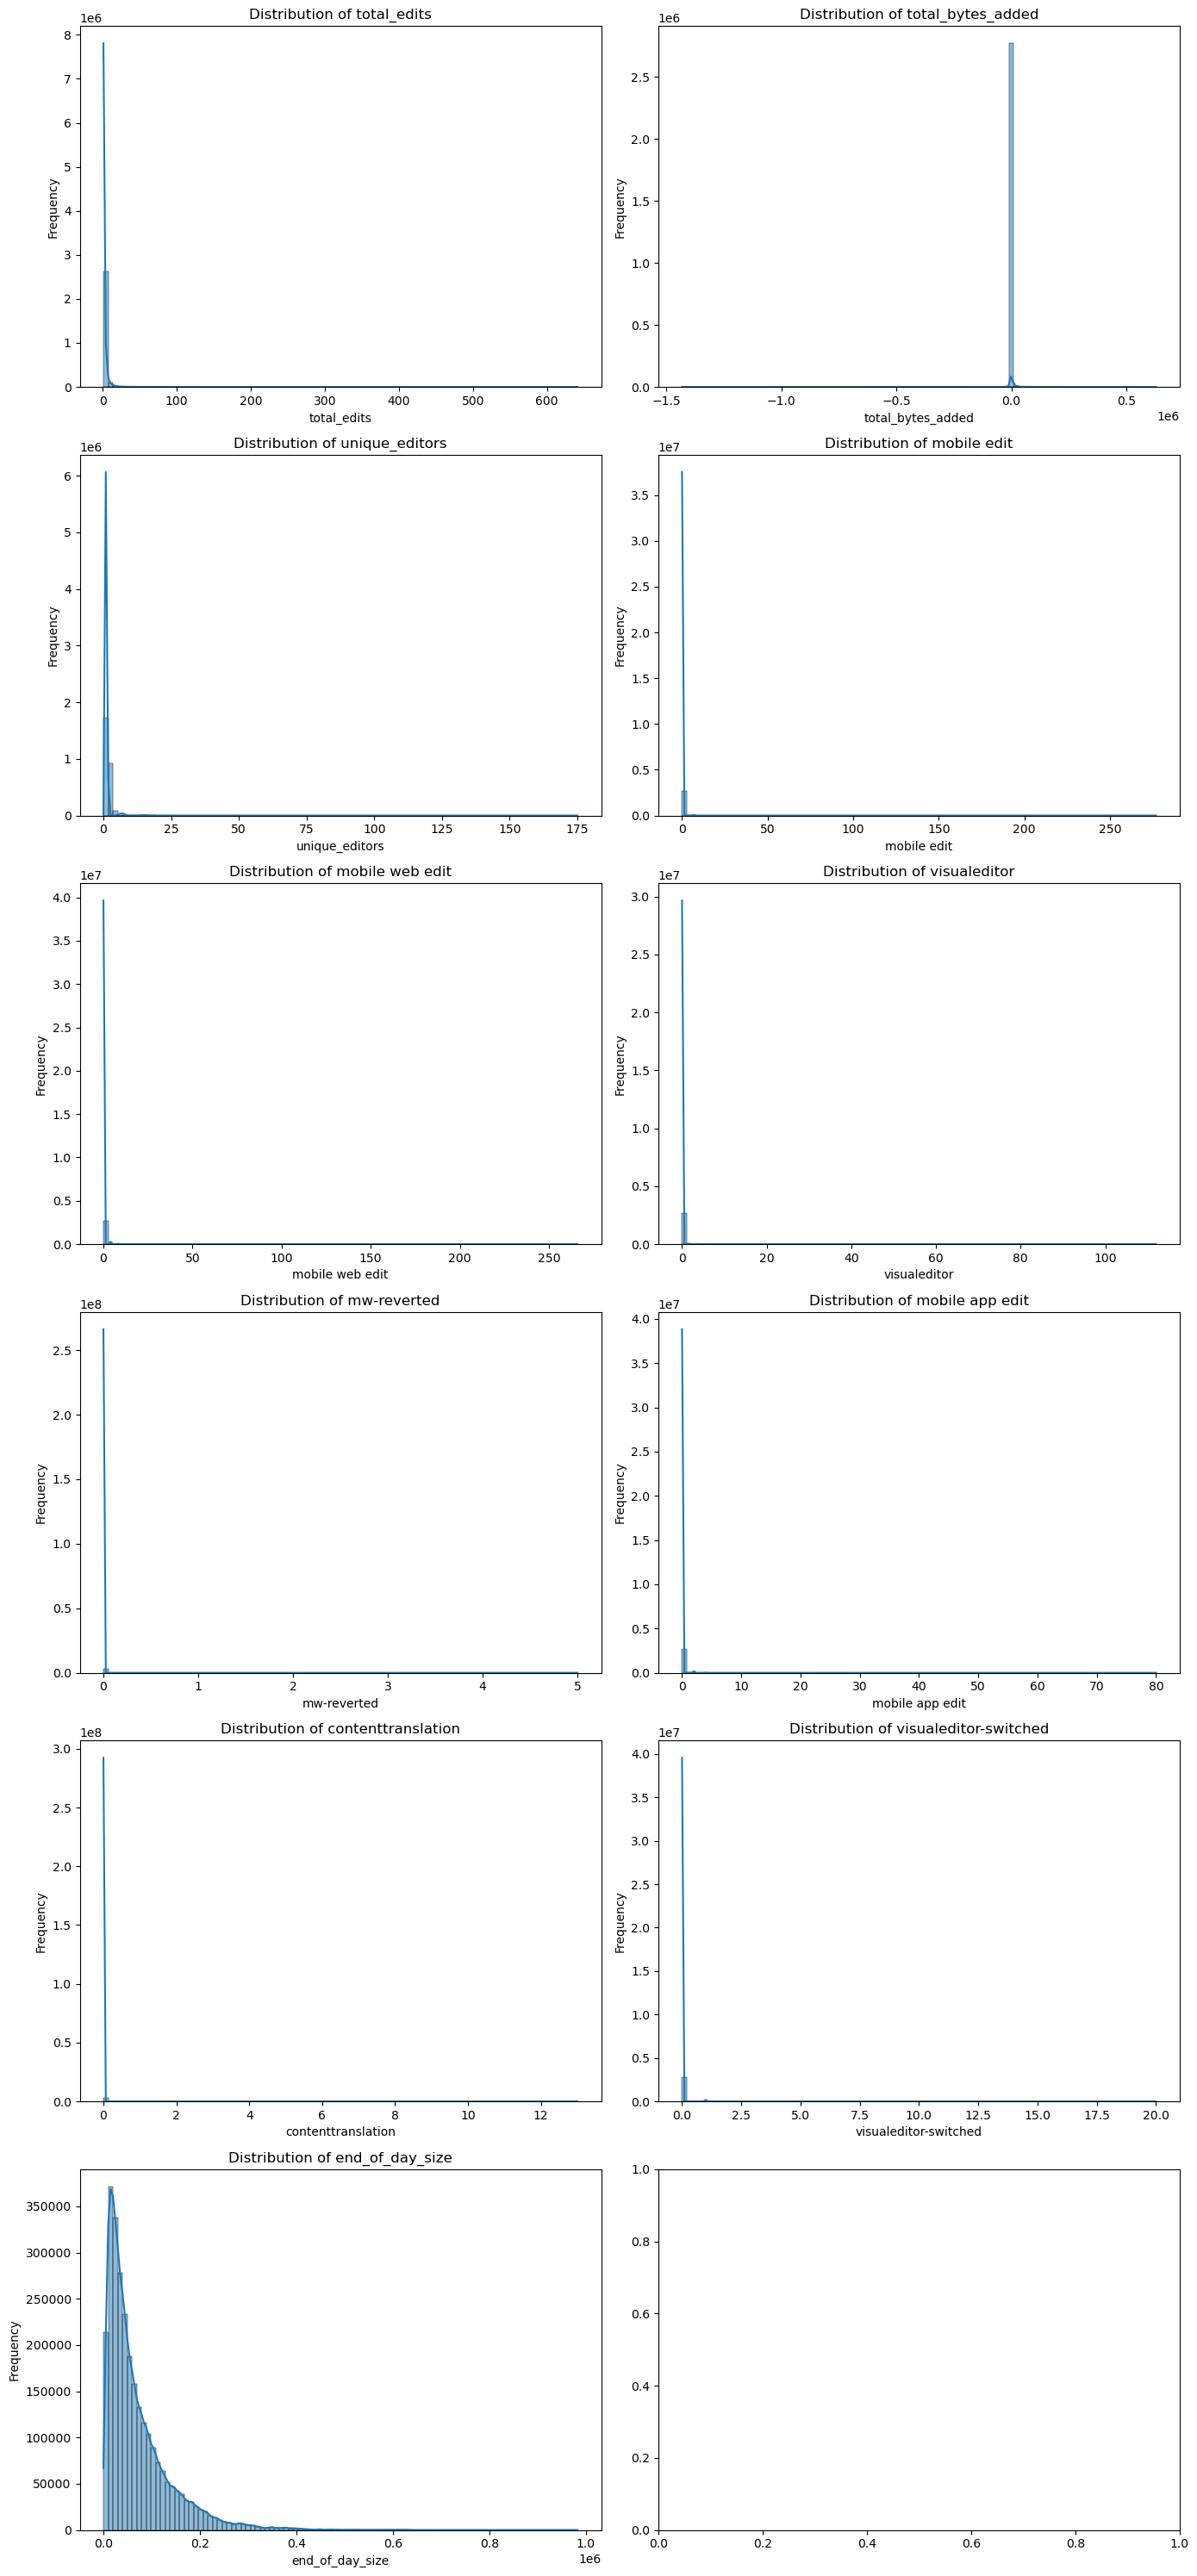

In [83]:
# Distribution of Numeric Features
num_features = len(numerical_features)
num_rows = math.ceil(num_features / 2)
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, num_rows * 5))

for i, feature in enumerate(numerical_features):
    sns.histplot(meta_df[feature], bins=100, kde=True, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Distribution of {feature}')
    axes[i // 2, i % 2].set_xlabel(feature)
    axes[i // 2, i % 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

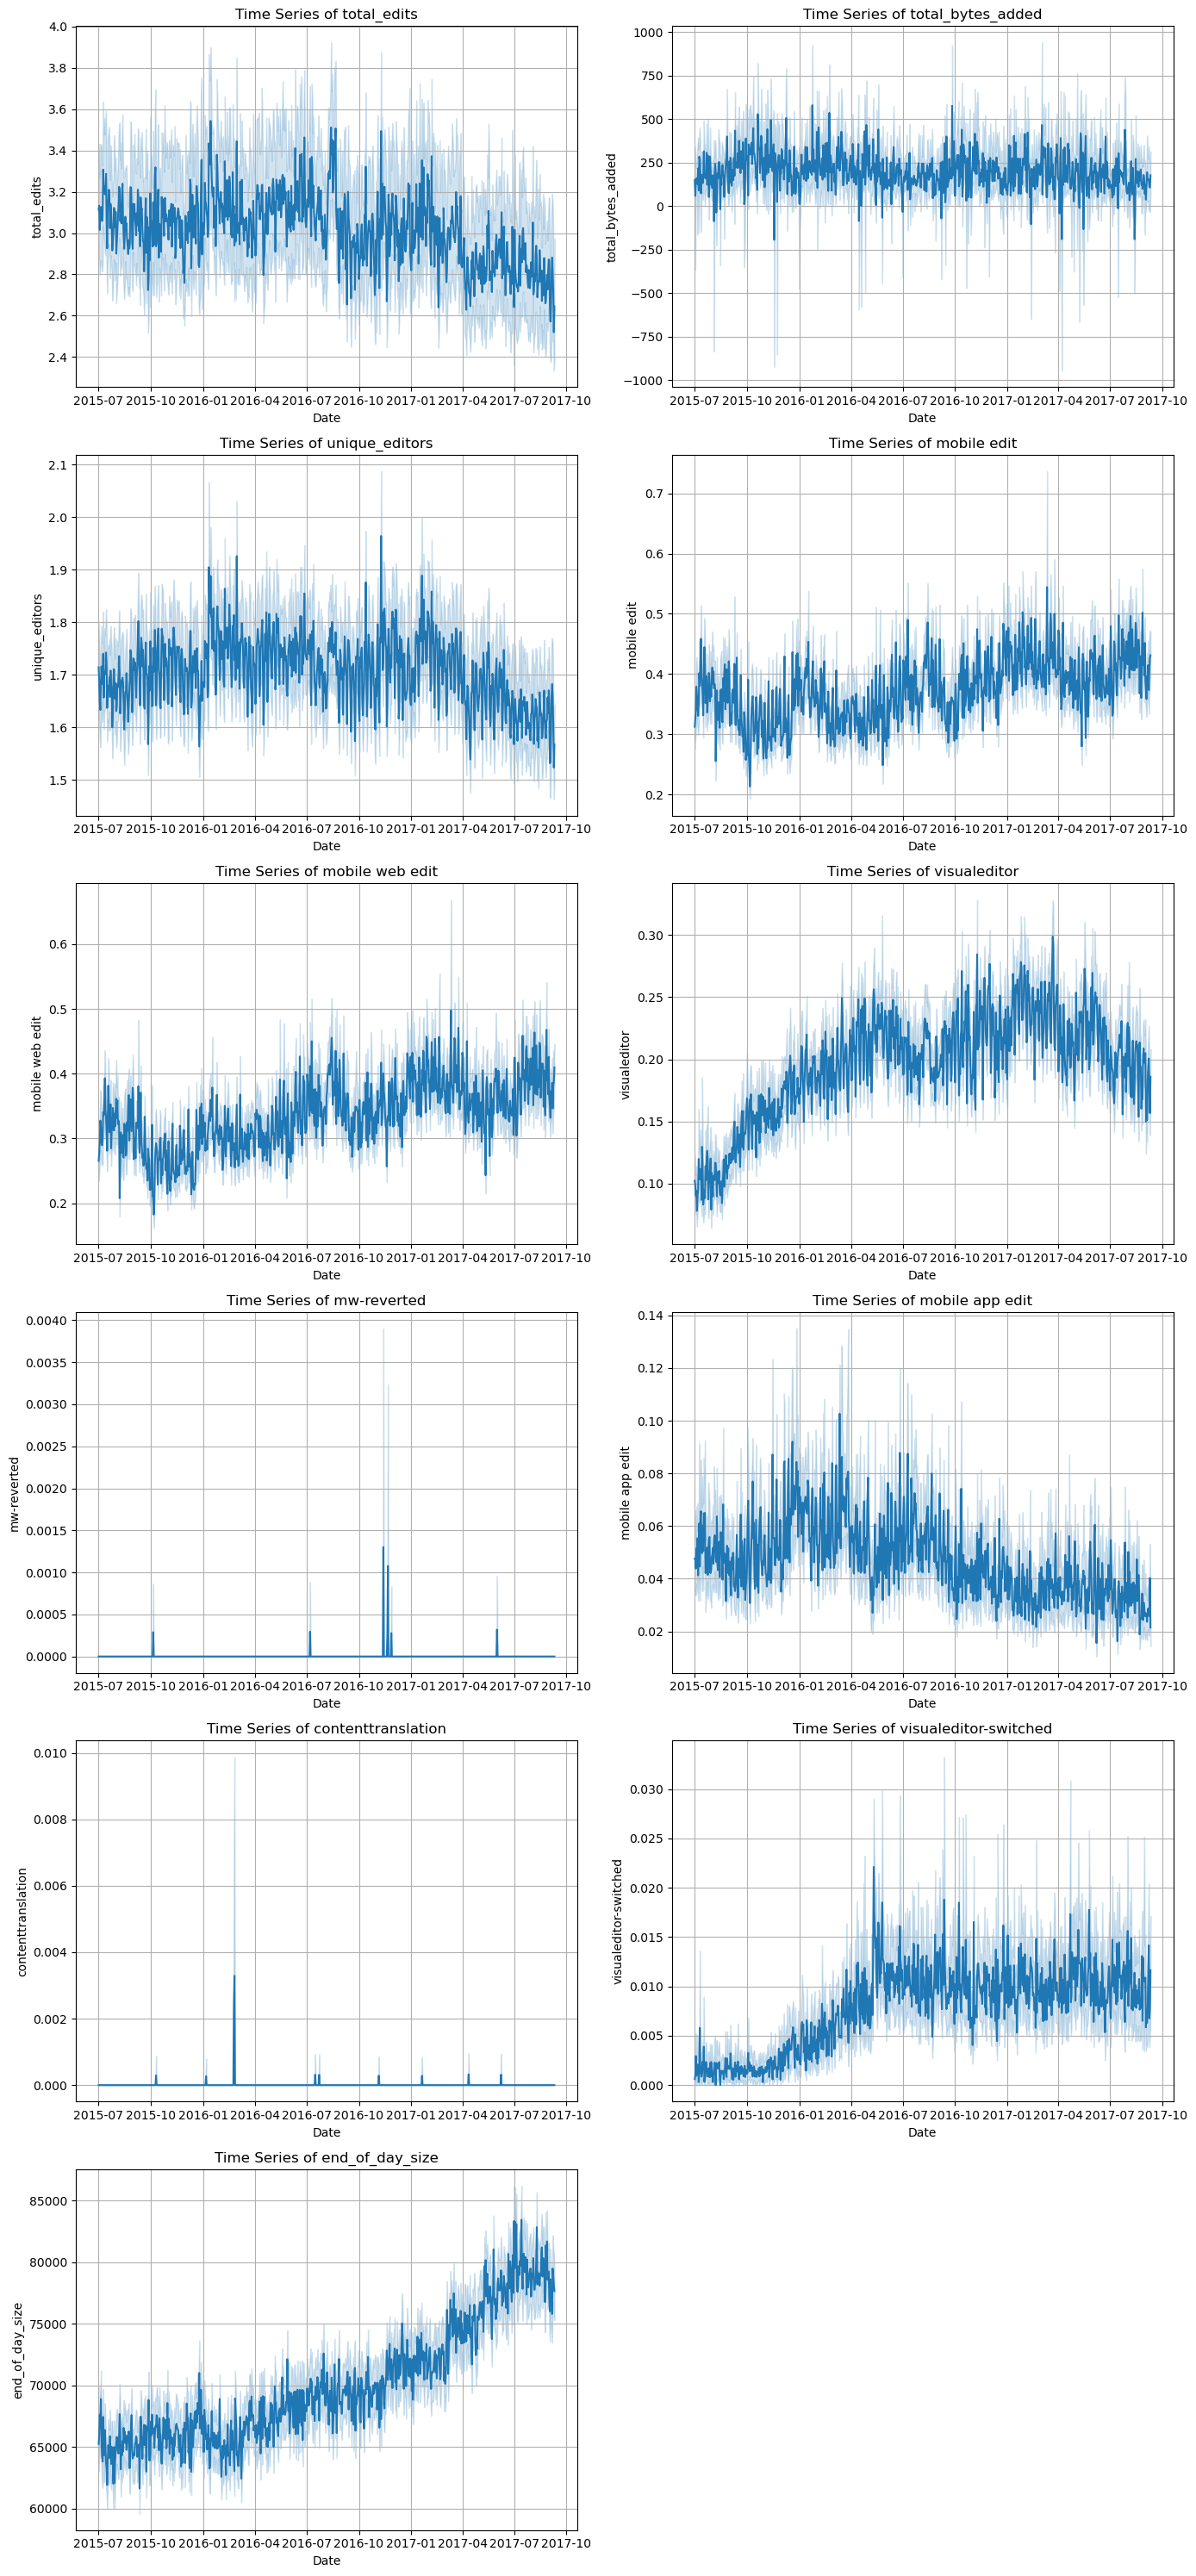

In [85]:
# Time Series Trends
num_features = len(numerical_features)
num_rows = math.ceil(num_features / 2)
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, num_rows * 5))

axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.lineplot(data=meta_df, x='date', y=feature, ax=axes[i])
    axes[i].set_title(f'Time Series of {feature}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(feature)
    axes[i].grid(True)

# Hide any unused subplots
if num_features % 2 != 0:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

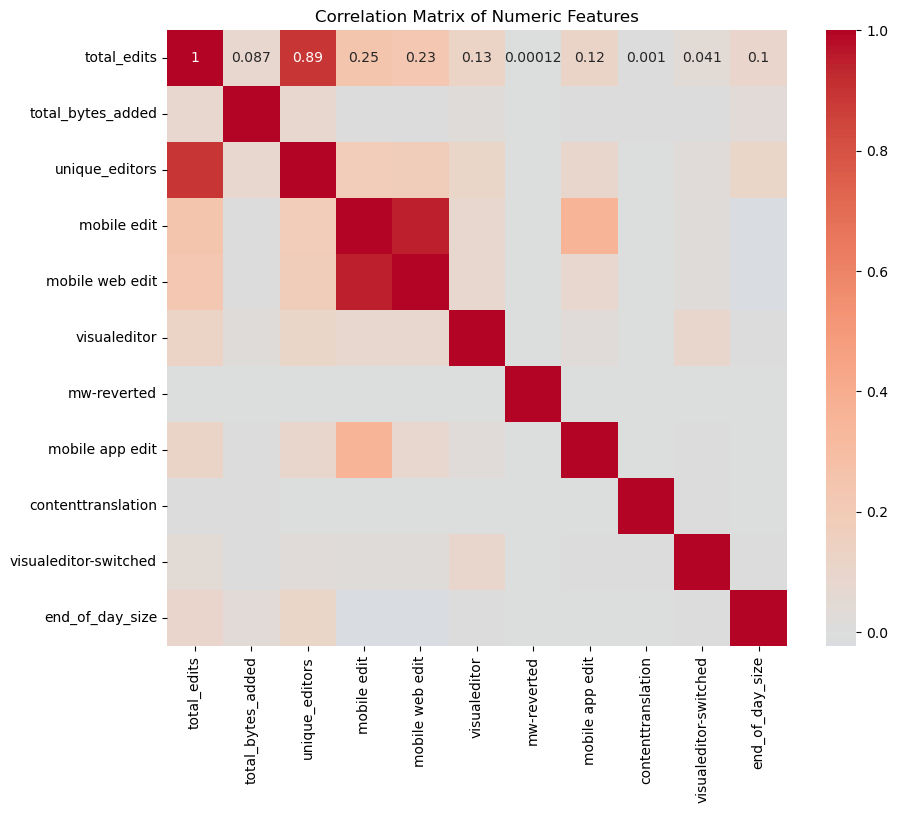

In [86]:
# Correlation Analysis
corr_matrix = meta_df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

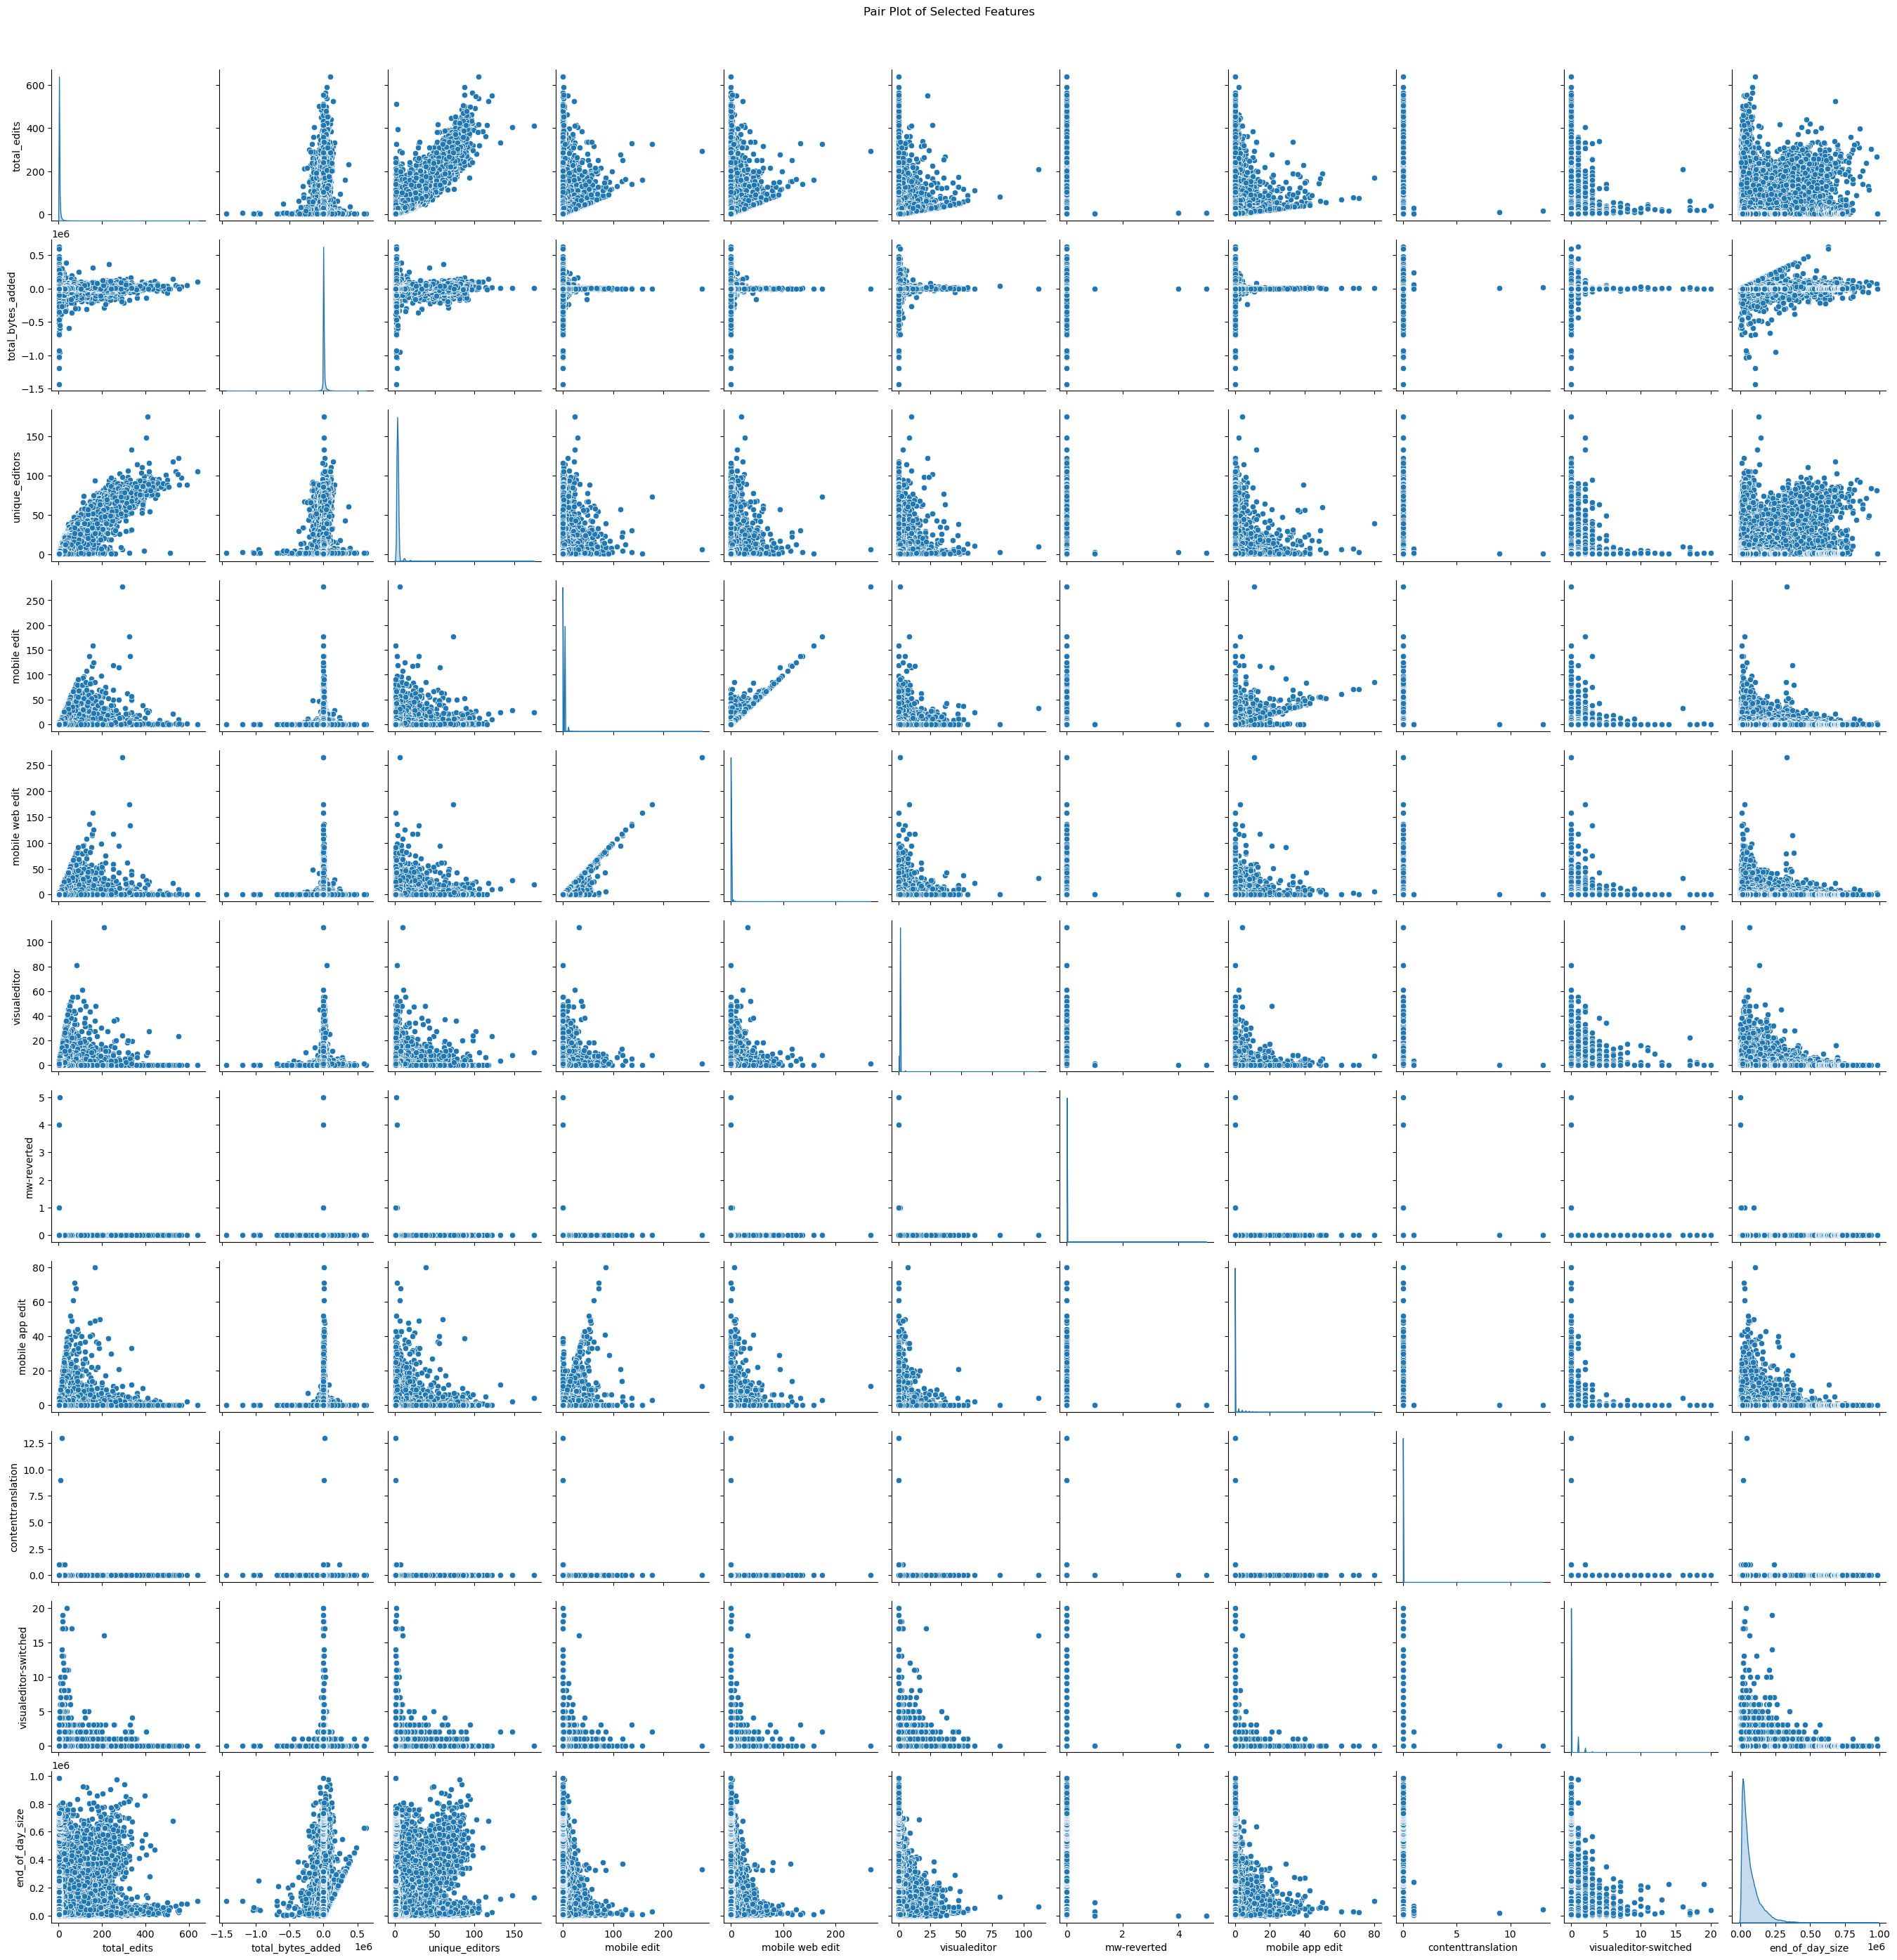

In [91]:
sns.pairplot(meta_df, vars=numerical_features, diag_kind='kde')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

In [ ]:
# page_info_df = page_info_df[['page', 'article', 'domain']].drop_duplicates()

# meta_df = meta_df.merge(page_info_df, on=['article', 'domain'], how='left')

# import pandas as pd

# start_period = '2016-06-01'
# end_period = '2016-08-31'

# high_view_pages = raw_data.loc[start_period:end_period].sum().sort_values(ascending=False).head(10).index

# meta_filtered_df = meta_df[meta_df['page'].isin(high_view_pages)]

# outlier_pages = raw_data.loc['2016-01-01':'2017-01-01'].sum().sort_values(ascending=False).head(10).index
# high_view_outliers = [page for page in high_view_pages if page in outlier_pages]

# print("High-view pages during specified period:", high_view_pages)
# print("Outlier pages identified previously:", outlier_pages)
# print("High-view pages that are also outliers:", high_view_outliers)
# print(f"Number of high-view pages that are also outliers: {len(high_view_outliers)}")

